In [1]:
# Use the Cor-Power WEC outline.

# Plot 1:
# Run a dummy Capytaine round to make sure the initial build happens and we're not timing that
# Run Capytaine with evenly-spaced increasing resolution, get times and values.
# Run MEEM with SAME number of terms/region, evenly-spaced increasing resolution, get times and values.
# Designated value at terms = 300 for MEEM.
# All runs should be repeated 5 times and time-averaged to reduce variability.
# Plot the values on the same plot. x = time, y = value.

# Plot 2:
# Stacked plot for a 2-region configuration, how much time each component takes for same terms/region.
# Terms on x, times on y.

# Plot 3:
# Which calculation dominates if you have y regions and x terms/region? Shares legend and colors with plot 2.

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from typing import List, Dict, Any, Optional
import pandas as pd
import openflash
print(type(openflash))
print(openflash.__path__)
print(openflash.__file__)


# --- Import core modules from package ---
try:
    from openflash import *
    from openflash.multi_equations import *
    from openflash.multi_constants import g
    print("OpenFLASH modules imported successfully!")
except ImportError as e:
    print(f"Error importing OpenFLASH modules. Error: {e}")

# Set NumPy print options for better readability
np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)
from openflash.multi_constants import rho #need for BEM

from time import perf_counter
from capytaine_generator import CapytaineSlantSolver


# Now you can import from the folder structure
# Assuming 'pyplotutilities' is a folder inside 'sea-lab-utils'
import sys
from pathlib import Path
HERE = Path.cwd().resolve()
utils_path = (HERE / ".." / ".." / "sea-lab-utils").resolve()
utils_str = str(utils_path)
if utils_str not in sys.path:
    sys.path.insert(0, utils_str)
from pyplotutilities import colors
colors.get_colors()
print(colors.purple)

figs_path_prefix = str((HERE / ".." / ".." / "pubs/JFM/figs").resolve())

<class 'module'>
['/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash']
/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash/__init__.py
OpenFLASH modules imported successfully!
#CC79A7


In [3]:
h = 50.00 # sea depth [m]
# omega_sweep = np.linspace(0.4, 1.5, 10) # rad/s
omega_val = 1
d_in = [14.45, 14.45-7.32-5.08] # drafts [m]
d_out = d_in # non-slanted version
a_list = [2.5/2, 8.4/2] # radii [m]
NMK = [100, 100, 100] # number of coefficients in each region
heaving = [1, 1]
face_dist = [a_list[0], d_in[0] - d_in[1], a_list[1] - a_list[0], d_in[1]]
face_fracs = [face_dist[i] / sum(face_dist) for i in range(4)]
cpt_divisions = 15
t_density_lst = [[6 + int(i * 27/cpt_divisions), 12 + int(i * 54/cpt_divisions)] for i in range(cpt_divisions)]
face_unit_lst = [10 + int(i * 40/cpt_divisions) for i in range(cpt_divisions)]
nmk_max = 300
nmk_lst = list(range(5, 101, 5))

config = {"h" : h,
          "a" : a_list,
          "d_in" : d_in,
          "d_out" : d_out,
          "heaving": heaving,
          "omega" : omega_val,
          "rho" : rho}

In [4]:
css = CapytaineSlantSolver(False, True, False, False, False)
def compute_cpt_slant(config, t_densities, face_units, reps):
  respack = css.construct_and_solve(config["a"], config["d_in"], config["d_out"], config["heaving"], t_densities, face_units, config["h"], config["omega"], config["rho"], reps)
  result, t_diff, result_d, t_diff_d, panel_count = respack
  am, dp = (result.added_mass)["Heave"], (result.radiation_damping)["Heave"]
  return am, dp, t_diff, t_diff_d, panel_count

In [ ]:
class TimedMEEMEngine(MEEMEngine):
    def __init__(self, problem_list: List[MEEMProblem]):
        """
        Initialize the MEEMEngine object.
        :param problem_list: List of MEEMProblem instances.
        """
        self.timing_dict = {}
        self.problem_list = problem_list
        self.cache_list = {} 

        t1 = perf_counter()
        for problem in problem_list:
            self.problem_cache_time_extractable(problem)
            self.cache_list[problem] = self.build_problem_cache(problem)
        t2 = perf_counter()
        self.timing_dict["A part 1"] = t2 - t1 - (self.timing_dict["I_nm"]
                                                  + self.timing_dict["Hydros part 1"]
                                                  + self.timing_dict["b part 1"])

    def _ensure_m_k_and_N_k_arrays(self, problem: 'MEEMProblem', m0):
        cache = self.cache_list[problem]
        if cache.m_k_arr is None or cache.cached_m0 != m0:
            domain_list = problem.domain_list
            domain_keys = list(domain_list.keys())
            NMK = [domain_list[idx].number_harmonics for idx in domain_keys]
            h = domain_list[0].h
            t1 = perf_counter()
            m_k_arr = np.array([cache.m_k_entry_func(k, m0, h) for k in range(NMK[-1])])
            t2 = perf_counter()
            N_k_arr = np.array([cache.N_k_func(k, m0, h, m_k_arr) for k in range(NMK[-1])])
            t3 = perf_counter()
            cache._set_precomputed_m_k_N_k(m_k_arr, N_k_arr, m0)
            self.timing_dict["mk"] = t2 - t1
            self.timing_dict["Nk"] = t3 - t2

    def assemble_A_multi(self, problem: 'MEEMProblem', m0) -> np.ndarray:
        self._ensure_m_k_and_N_k_arrays(problem, m0)
        cache = self.cache_list[problem]
        A = cache._get_A_template()
        t1 = perf_counter()
        I_mk_vals = cache._get_closure("I_mk_vals")(m0, cache.m_k_arr, cache.N_k_arr)
        t2 = perf_counter()
        for row, col, calc_func in cache.m0_dependent_A_indices:
            A[row, col] = calc_func(problem, m0, cache.m_k_arr, cache.N_k_arr, I_mk_vals)
        t3 = perf_counter()
        self.timing_dict["I_mk"] = t2 - t1
        self.timing_dict["A part 2"] = t3 - t2
        return A
                
    def assemble_b_multi(self, problem: 'MEEMProblem', m0) -> np.ndarray:
        self._ensure_m_k_and_N_k_arrays(problem, m0)
        cache = self.cache_list[problem]
        b = cache._get_b_template()
        I_mk_vals = cache._get_closure("I_mk_vals")(m0, cache.m_k_arr, cache.N_k_arr)
        t1 = perf_counter()
        for row, calc_func in cache.m0_dependent_b_indices:
            b[row] = calc_func(problem, m0, cache.m_k_arr, cache.N_k_arr, I_mk_vals)
        t2 = perf_counter()
        self.timing_dict["b part 2"] = t2 - t1
        return b
    
    def problem_cache_time_extractable(self, problem : 'MEEMProblem'):
        cache = ProblemCache(problem)
        domain_list = problem.domain_list
        domain_keys = list(domain_list.keys())
        
        h = domain_list[0].h
        d = [domain_list[idx].di for idx in domain_keys]
        a = [domain_list[idx].a for idx in domain_keys]
        NMK = [domain.number_harmonics for domain in domain_list.values()]
        heaving = [domain_list[idx].heaving for idx in domain_keys]
        
        boundary_count = len(NMK) - 1
        size = NMK[0] + NMK[-1] + 2 * sum(NMK[1:len(NMK) - 1])


        t1 = perf_counter()
        # 2. Pre-compute m0-INDEPENDENT values
        I_nm_vals_precomputed = [np.zeros((NMK[bd], NMK[bd+1]), dtype = complex) for bd in range(boundary_count - 1)]
        for bd in range(boundary_count - 1):
            for n in range(NMK[bd]):
                for m in range(NMK[bd + 1]):
                    I_nm_vals_precomputed[bd][n, m] = I_nm(n, m, bd, d, h)
        cache._set_I_nm_vals(I_nm_vals_precomputed)
        t2 = perf_counter()

        # These are purely geometric and geometry is constant for the problem
        int_R1_store = {}
        int_R2_store = {}
        int_phi_store = np.zeros(boundary_count, dtype=complex)

        # Pre-compute R1 integrals (used in all regions)
        for i in range(boundary_count):
            for n in range(NMK[i]):
                # Store as tuple key (region_idx, harmonic_n)
                int_R1_store[(i, n)] = int_R_1n(i, n, a, h, d)
        
        # Pre-compute R2 integrals (used in annular regions i > 0)
        for i in range(1, boundary_count):
            for n in range(NMK[i]):
                int_R2_store[(i, n)] = int_R_2n(i, n, a, h, d)

        # Pre-compute Phi_p integrals (used for Force calculation)
        for i in range(boundary_count):
            int_phi_store[i] = int_phi_p_i(i, h, d, a)
        t3 = perf_counter()

        b_template = np.zeros(size, dtype=complex)
        index = 0
        for bd in range(boundary_count):
            if bd == (boundary_count - 1):
                for n in range(NMK[-2]):
                    b_template[index] = b_potential_end_entry(n, bd, heaving, h, d, a)
                    index += 1
            else:
                num_entries = NMK[bd + (d[bd] <= d[bd + 1])]
                for n in range(num_entries):
                    b_template[index] = b_potential_entry(n, bd, d, heaving, h, a)
                    index += 1

        for bd in range(boundary_count):
            if bd == (boundary_count - 1):
                for n_local in range(NMK[-1]):
                    calc_func = lambda p, m0, mk, Nk, Imk, n=n_local: \
                        b_velocity_end_entry(n, bd, heaving, a, h, d, m0, NMK, mk, Nk)
                    cache._add_m0_dependent_b_entry(index, calc_func)
                    index += 1
            else:
                num_entries = NMK[bd + (d[bd] > d[bd + 1])]
                for n in range(num_entries):
                    b_template[index] = b_velocity_entry(n, bd, heaving, a, h, d)
                    index += 1
        t4 = perf_counter()
        
        self.timing_dict["I_nm"] = t2 - t1
        self.timing_dict["Hydros part 1"] = t3 - t2
        self.timing_dict["b part 1"] = t4 - t3

    def solve_linear_system_multi(self, problem: MEEMProblem, m0) -> np.ndarray:
        cache = self.cache_list[problem]
        self._ensure_m_k_and_N_k_arrays(problem, m0)
        A = self.assemble_A_multi(problem, m0)
        b = self.assemble_b_multi(problem, m0) 
        t1 = perf_counter()
        X = linalg.solve(A, b)
        t2 = perf_counter()
        self.timing_dict["Matrix Solve"] = t2 - t1
        return X
    
    def timed_hydros(self, problem: MEEMProblem, X, m0):
        t1 = perf_counter()
        results_per_mode = self.compute_hydrodynamic_coefficients(problem, X, m0)
        t2 = perf_counter()
        self.timing_dict["Hydros part 2"] = t2 - t1
        return results_per_mode
    

In [91]:
def timed_MEEM(config, nmk):
  t1 = perf_counter()
  NMK = [nmk for _ in range(len(config["a"]) + 1)]
  arrangement = ConcentricBodyGroup([SteppedBody(a=np.array(config["a"]),
                                                 d=np.array(config["d_in"]),
                                                 slant_angle= np.array([0, 0]),
                                                 heaving=True)])
  geometry = BasicRegionGeometry(body_arrangement=arrangement, h=config["h"], NMK=NMK)
  problem = MEEMProblem(geometry)
  problem.set_frequencies(np.array([omega_val]))
  engine = TimedMEEMEngine(problem_list=[problem])
  assert engine.cache_list[problem].m_k_arr is None
  m0 = wavenumber(omega_val, config["h"])
  X = engine.solve_linear_system_multi(problem, m0)
  results_per_mode = engine.timed_hydros(problem, X, m0)
  t2 = perf_counter()
  data = engine.timing_dict
  data["Total Time"] = (t2 - t1) - (data["I_nm"] + data["Hydros part 1"] + data["b part 1"]) # This part was run in excess
  data["Hydro real"] = results_per_mode[0]["real"]
  data["Hydro imag"] = results_per_mode[0]["imag"]
  return data

In [92]:
reps = 20
cpt_data = []
_ = compute_cpt_slant(config, [20, 40], 36, 1) # dummy for compilation
for i in range(cpt_divisions):
  am, dp, t_diff, t_diff_d, panel_count = compute_cpt_slant(config, t_density_lst[i], face_unit_lst[i], reps)
  cpt_data.append({"Added Mass" : am,
                   "Damping" : dp,
                   "Computation Time" : t_diff + t_diff_d,
                   "Panel Count" : panel_count})
  
meem_data = []
for nmk in nmk_lst:
  rep_set = [timed_MEEM(config, nmk) for _ in range(reps)]
  output = {key : sum([rep_set[i][key] for i in range(reps)])/reps for key in rep_set[0].keys()}
  output["terms per region"] = nmk
  meem_data.append(output)

high_nmk_data_set = timed_MEEM(config, nmk_max)
true_am, true_dp = high_nmk_data_set["Hydro real"], high_nmk_data_set["Hydro imag"]

Panel Count:  920
Panel Count:  72
Panel Count:  100
Panel Count:  175
Panel Count:  253
Panel Count:  325
Panel Count:  435
Panel Count:  535
Panel Count:  637
Panel Count:  780
Panel Count:  946
Panel Count:  1104
Panel Count:  1235
Panel Count:  1442
Panel Count:  1624
Panel Count:  1860


/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_5783/2490445994.py:145: LinAlgWarning: Ill-conditioned matrix (rcond=3.84051e-29): result may not be accurate.
  X = linalg.solve(A, b)


In [109]:
named_meem_times = ["Coupling Integrals", "Root Finding", "Matrix Solve",
                    "Bessels (Excluding in Hydro Coefficients)", "Hydro Coefficients"]

def reorganize_MEEM_information(data):
  output = {}
  output["Coupling Integrals"] = data["I_nm"] + data["I_mk"]
  output["Root Finding"] = data["mk"]
  output["Matrix Solve"] = data["Matrix Solve"]
  output["Bessels (Excluding in Hydro Coefficients)"] = data["A part 1"] + data["A part 2"]
  output["Hydro Coefficients"] = data["Hydros part 1"] + data["Hydros part 2"]
  output["Total Time"] = data["Total Time"]
  output["Other/Overhead"] = data["Total Time"] - sum([output[key] for key in named_meem_times])
  output["Added Mass"] = data["Hydro real"]
  output["Damping"] = data["Hydro imag"]
  output["nmk"] = data["terms per region"]
  return output

meem_reorganized_data = [reorganize_MEEM_information(data) for data in meem_data]

In [98]:
# Plot Settings
l_width = 3 # line width
m_size = 7 # marker size
lab_fs = 12 # x and y label font size
leg_fs = lab_fs * 0.8 # legend font size
fig_h = 6 # figure height
fig_w = 5 # figure width

Text(0, 0.5, 'Damping [Ns/m]')

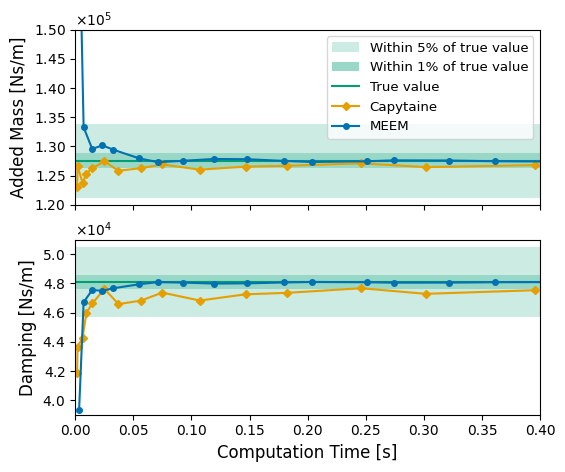

In [ ]:
cpt_times = [data["Computation Time"] for data in cpt_data]
meem_times = [data["Total Time"] for data in meem_reorganized_data]

fig, ax = plt.subplots(2, 1, figsize=(fig_h, fig_w), sharex = True)
for a in ax:
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1)) 
    a.yaxis.set_major_formatter(formatter)

xlim_max = 0.4
true_color = colors.green
ax[0].axhspan(1.01 * true_am, 1.05 * true_am, alpha=0.2, color = true_color,
           linewidth=0, label = "Within 5% of true value")
ax[0].axhspan(0.99 * true_am, 1.01 * true_am, alpha=0.4, color = true_color,
           linewidth=0, label = "Within 1% of true value")
ax[0].axhspan(0.95 * true_am, 0.99 * true_am, alpha=0.2, color = true_color,
           linewidth=0)
ax[0].axhline(true_am, linestyle="-", linewidth=l_width-1.5, color = true_color,
           label = "True value")
ax[0].plot(cpt_times, [data["Added Mass"] for data in cpt_data], color = colors.orange,
        marker='D', markersize=m_size-3, label = "Capytaine")
ax[0].plot(meem_times, [data["Added Mass"] for data in meem_reorganized_data], color=colors.blue,
        marker='o', markersize=m_size-3, label = "MEEM")

ax[0].set_ylim([1.2e5, 1.5e5])
ax[0].set_xlim([0, xlim_max])
ax[0].legend(loc='upper right', fontsize=leg_fs, frameon=True)

ax[1].yaxis.set_major_formatter(formatter)
ax[1].axhspan(1.01 * true_dp, 1.05 * true_dp, alpha=0.2, color = true_color,
           linewidth=0)
ax[1].axhspan(0.99 * true_dp, 1.01 * true_dp, alpha=0.4, color = true_color,
           linewidth=0)
ax[1].axhspan(0.95 * true_dp, 0.99 * true_dp, alpha=0.2, color = true_color,
           linewidth=0)
ax[1].axhline(true_dp, linestyle="-", linewidth=l_width-1.5, color = true_color)
ax[1].plot(cpt_times, [data["Damping"] for data in cpt_data], color = colors.orange,
        marker='D', markersize=m_size-3, label = "Capytaine")
ax[1].plot(meem_times, [data["Damping"] for data in meem_reorganized_data], color=colors.blue,
        marker='o', markersize=m_size-3, label = "MEEM")

ax[1].set_xlim([0, xlim_max])
ax[1].set_ylim([3.9e4, 5.1e4])
ax[1].set_xlabel('Computation Time [s]', fontsize=lab_fs)
ax[0].set_ylabel('Added Mass [Ns/m]', fontsize=lab_fs)
ax[1].set_ylabel('Damping [Ns/m]', fontsize=lab_fs)

full_path = figs_path_prefix + "MEEM-CPT-Speed-Comparison.pdf"
fig.savefig(full_path, format='pdf', dpi=300, bbox_inches='tight')


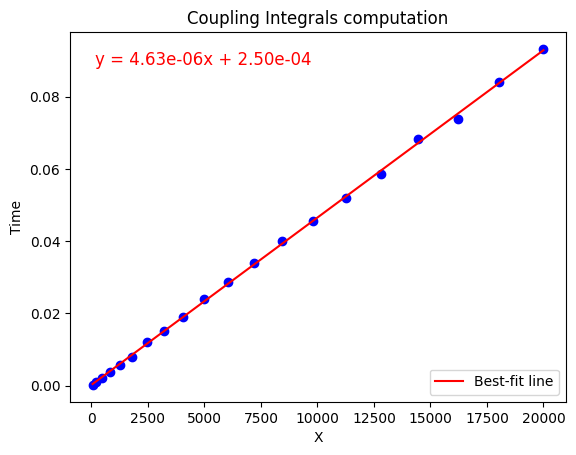

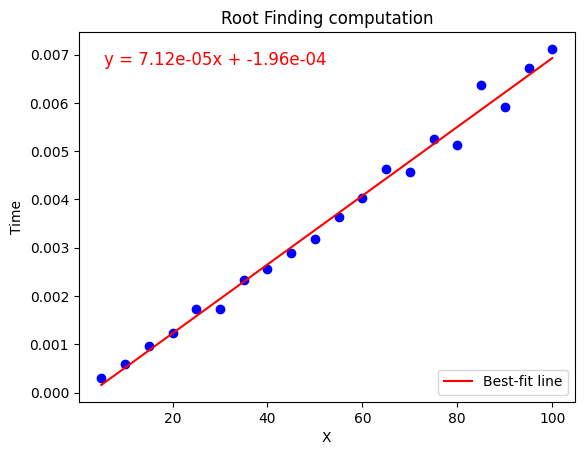

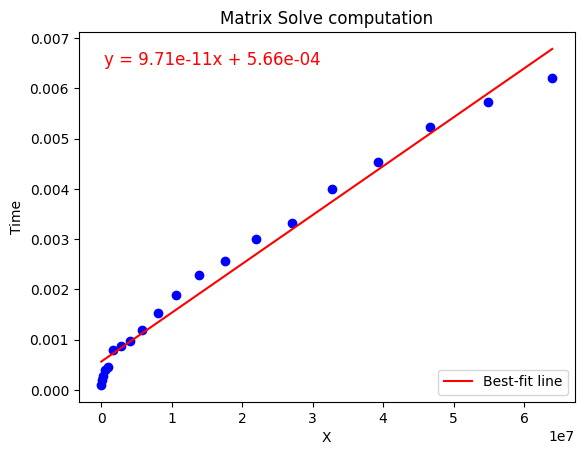

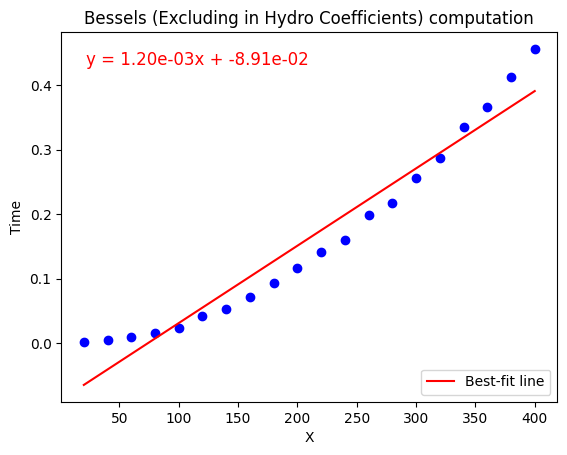

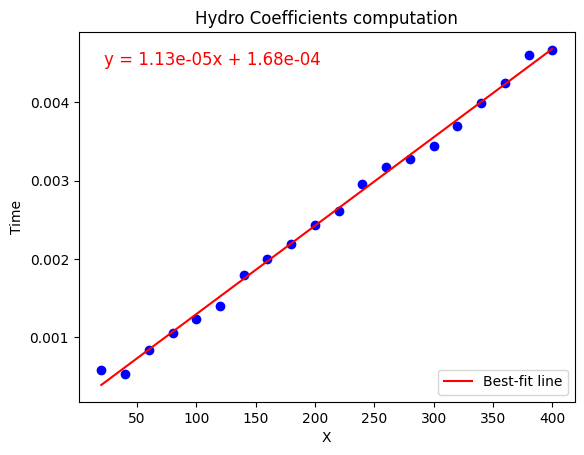

In [149]:
total_unknown_coeffs = lambda NMK: NMK[0] + 2 * sum(NMK[1:-1]) + NMK[-1]
coupling_dep = lambda NMK: sum([NMK[i] * NMK[i+1] for i in range(len(NMK)-1)])
time_dependencies = {"Coupling Integrals" : lambda NMK : coupling_dep(NMK),
                     "Root Finding" : lambda NMK : NMK[-1],
                     "Matrix Solve" : lambda NMK : (total_unknown_coeffs(NMK))**3,
                    "Bessels (Excluding in Hydro Coefficients)" : lambda NMK : total_unknown_coeffs(NMK),
                    "Hydro Coefficients" : lambda NMK : total_unknown_coeffs(NMK)}

def plot_dependence(meem_data, key, xlab):
  xs = []
  ys = []
  NMKs = [[data["nmk"] for i in range(3)] for data in meem_data]
  for i in range(len(meem_data)):
    xs.append(time_dependencies[key](NMKs[i]))
    ys.append(meem_data[i][key])
  plt.scatter(xs, ys, color = "blue")
  coeffs = np.polyfit(xs, ys, deg=1)
  fit_fn = np.poly1d(coeffs)
  x_line = np.linspace(min(xs), max(xs), 100)
  slope, intercept = coeffs
  equation = f"y = {slope:.2e}x + {intercept:.2e}"
  plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes,
          fontsize=12, verticalalignment='top', color='red')
  plt.plot(x_line, fit_fn(x_line), color="red", label="Best-fit line")
  plt.xlabel(xlab)
  plt.ylabel("Time")
  plt.legend()
  plt.title(key + " computation")
  plt.show()
  return slope

tds_factors = {key : plot_dependence(meem_reorganized_data, key, "X") for key in named_meem_times}


In [176]:
# Plot Settings
l_width = 3 # line width
m_size = 7 # marker size
lab_fs = 10 # x and y label font size
leg_fs = lab_fs * 0.9 # legend font size
fig_h = 10 # figure height
fig_w = 4 # figure width

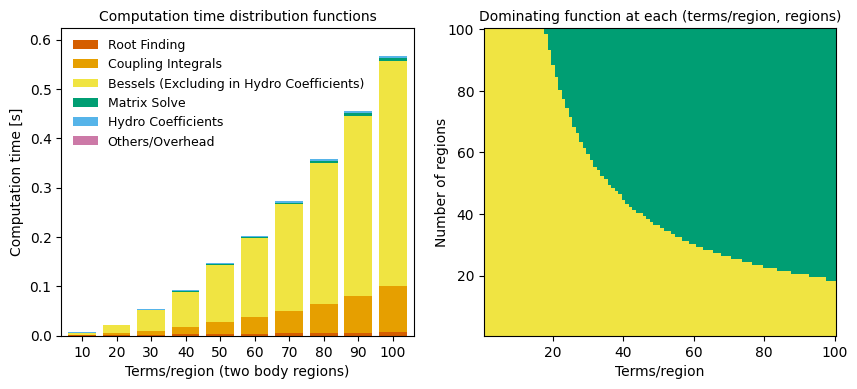

In [188]:
key_colors = {"Root Finding" : colors.red,
              "Coupling Integrals" : colors.orange,
              "Bessels (Excluding in Hydro Coefficients)" : colors.yellow,
              "Matrix Solve" : colors.green,
              "Hydro Coefficients" : colors.skyblue,
              "Others/Overhead" : colors.purple}

def bar_chart(ax, meem_reorganized_data, key_colors):
  x = np.array([data["nmk"] for data in meem_reorganized_data])
  bottom = np.zeros(len(meem_reorganized_data))
  for k in key_colors.keys():
    heights = np.array([record.get(k, 0) for record in meem_reorganized_data])
    ax.bar(x, heights, bottom=bottom, width= 8, color=key_colors[k], label=k)
    bottom += heights

  ax.set_xticks(x)
  ax.set_xlabel("Terms/region (two body regions)", fontsize=lab_fs)
  ax.set_ylabel("Computation time [s]", fontsize=lab_fs)
  ax.legend(loc='upper left', fontsize=leg_fs, frameon=False)
  ax.set_ylim([0, max(bottom) * 1.1])
  ax.set_xlim([min(x) - 6, max(x) + 6])
  ax.set_title("Computation time distribution functions", fontsize=lab_fs, pad=5)

def times_contour(ax, key_colors, 
                  nmks, regions_lst,
                  time_dependencies, tds_factors):
  X, Y = np.meshgrid(nmks, regions_lst)
  keys = time_dependencies.keys()

  func_to_int = {key: i for i, key in enumerate(keys)}

  labels = np.zeros((len(regions_lst), len(nmks)), dtype = int)

  for j, regions in enumerate(regions_lst):
    for i, nmk in enumerate(nmks):
        NMK = [nmk for _ in range(regions)]
        results = {key : tds_factors[key] * time_dependencies[key](NMK) for key in keys}
        # get the function with the maximum (slowest) runtime
        slowest_func = max(results, key=results.get)
        labels[j, i] = func_to_int[slowest_func]

  colors_in_order = [key_colors[key] for key in keys]
  cmap = ListedColormap(colors_in_order)
  norm = BoundaryNorm(np.arange(-0.5, len(colors_in_order)+0.5), len(colors_in_order))
  extent = [nmks[0] - 0.5, nmks[-1] + 0.5,
            regions_lst[0] - 0.5, regions_lst[-1] + 0.5]

  im = ax.imshow(labels, cmap=cmap, norm=norm, origin="lower", extent=extent, interpolation="none", aspect="auto")

  ax.set_xlim([nmks[0] - 0.5, nmks[-1] + 0.5])
  ax.set_ylim([regions_lst[0] - 0.5, regions_lst[-1] + 0.5])
  ax.set_xlabel("Terms/region", fontsize=lab_fs)
  ax.set_ylabel("Number of regions", fontsize=lab_fs, labelpad=-1)
  ax.set_title("Dominating function at each (terms/region, regions)", fontsize=lab_fs, pad=5)

fig, ax = plt.subplots(1, 2, figsize=(fig_h, fig_w))
reduced_meem_data = [meem_reorganized_data[i] for i in range(len(meem_reorganized_data)) if i%2 == 1]
bar_chart(ax[0], reduced_meem_data, key_colors)
times_contour(ax[1], key_colors, list(range(1, 101)), list(range(1, 101)), time_dependencies, tds_factors)

full_path = figs_path_prefix + "/MEEM-Comp-Distribution.pdf"
fig.savefig(full_path, format='pdf', dpi=300, bbox_inches='tight')

# TODO Fix a bug! These plots don't match the ones I made in the convergence study branch
# Either bessel computation is taking too long, or the overhead lumped into the bessel function measurement is extreme.

In [186]:
# print(5.25e-10 * (200)**3 + 4.77e-2)
# print(5.39e-8 * (200)**2 + 2.19e-3)
# print(3.68e-6 * (100*2)*2 + 4.41e-3)
# print(4.93e-5 * (200) + 2.03e-4)